# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [90]:
!pip install scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [91]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np, pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in sklearn
from sklearn.metrics import mean_squared_error

# Import the Dataset and Reader classes from Surprise for creating and reading the dataset
from surprise import Dataset, Reader

# Import the train_test_split function from model_selection for splitting the data into training and testing sets
from surprise.model_selection import train_test_split

# Import the SVD algorithm from Surprise (you can choose a different algorithm if needed)
from surprise import SVD

# Import the accuracy module from Surprise for evaluating the recommendation system's performance
from surprise import accuracy

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering



### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [92]:

#Import the dataset
file='/content/drive/MyDrive/ratings_Electronics.csv'
column_names = ['user_id', 'prod_id', 'rating', 'timestamp']
data = pd.read_csv(file, names=column_names)
data.head()
#drop timestamp since we wont be using it
df = data.drop("timestamp",axis=1)
df.head(2)




,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0


In [93]:
#check info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB




*   There are 7824482 rows and 3 columns in the dataset





**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [94]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [95]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [96]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [97]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [98]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [99]:

# Check the number of rows and columns and provide observations
num_rows, num_columns = df_final.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)


Number of rows: 65290
Number of columns: 3


### **Observations**


* After filtering the dataframe, now we have 65290 rows/entries and 3 columns.




### **Data types**

In [100]:

# Check data types and provide observations
data_types = df_final.dtypes
print("Data types:")
print(data_types)


Data types:
user_id     object
prod_id     object
rating     float64
dtype: object


### **Observations**


*   We have **three columns**, out of which the user_id and prod_id are of data type object and rating is in float.






### **Checking for missing values**

In [101]:
# Check for missing values present and provide observations
missing_values = df_final.isnull().sum()
print("Missing values:")
print(missing_values)

Missing values:
user_id    0
prod_id    0
rating     0
dtype: int64


### **Observations**
The dataset is good as it contains 0 missing values.

### **Summary Statistics**

In [102]:
# Summary statistics of 'rating' variable and provide observations
rating_statistics = df_final['rating'].describe()
print("Summary statistics of 'rating' variable:")
print(rating_statistics)

Summary statistics of 'rating' variable:
count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


### **Observations**


* **Count**: The dataset contains a total of 65,290 ratings for products. This count indicates that you have a substantial amount of user feedback to work with.

* **Mean**: The mean rating is approximately 4.29. This suggests that, on average, users tend to rate products positively, as the mean rating is closer to the maximum value of 5.0. Users seem to be generally satisfied with the products they rate.

* **Standard Deviation**: The standard deviation of approximately 0.99 indicates some variability in ratings. While the mean is relatively high, the standard deviation suggests that there is a moderate level of dispersion in the ratings. This could mean that while the average rating is positive, there is still some variance in user opinions


* **Minimum and Maximum:** The minimum rating is 1.0, and the maximum rating is 5.0. This range suggests that users use the entire scale for rating, which is a positive aspect, as it allows for a comprehensive assessment of products.

* **Percentiles**: The 25th percentile (Q1) is 4.0, the median (50th percentile) is 5.0, and the 75th percentile (Q3) is 5.0. This indicates that a significant proportion of ratings (at least 50%) are at the high end of the scale, with ratings of 5.0. The interquartile range (IQR) is narrow, suggesting that most ratings are concentrated in the upper range.





### **Checking the rating distribution**

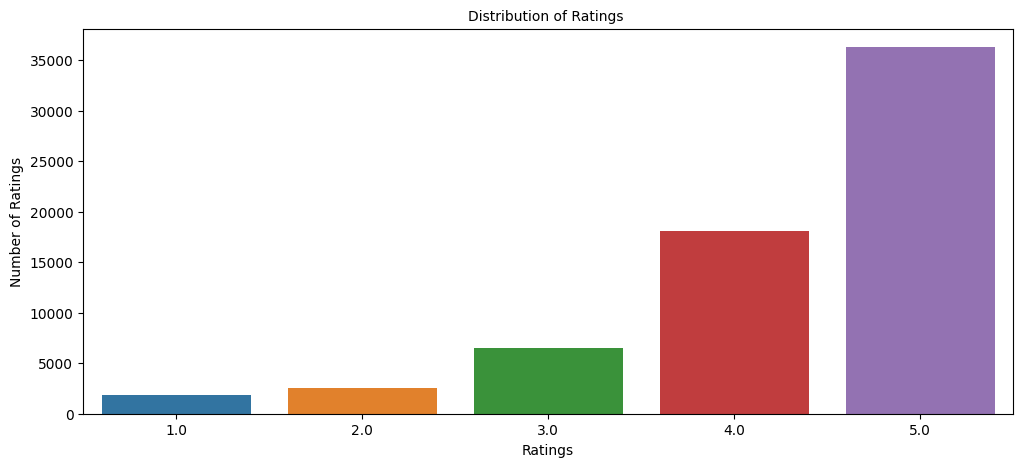

In [103]:
# Create the bar plot and provide observations
# Fix the figure size
plt.figure(figsize = (12, 5))

ax = sns.countplot(x = "rating", data = df_final)

plt.tick_params(labelsize = 10)

plt.title("Distribution of Ratings ", fontsize = 10)

# Set the xlabel of the plot
plt.xlabel("Ratings", fontsize = 10)

# Set the ylabel of the plot
plt.ylabel("Number of Ratings", fontsize = 10)

# Display the plot
plt.show()

### **Observations**


*   The data seemed to be **highly skewed towards the rating 5**.It is the first highest in the count and 4 is the second highest but it is comparitively lesser than rating 5.
*   Very few people have given **rating 1-3** which means, people don't rate the product they are not in favour with.



### **Checking the number of unique users and items in the dataset**

In [104]:
# Number of total rows in the data and number of unique user id and product id in the data

unique_user_ids = df_final['user_id'].nunique()
unique_product_ids = df_final['prod_id'].nunique()

print("Number of unique user IDs in the data:", unique_user_ids)
print("Number of unique product IDs in the data:", unique_product_ids)


Number of unique user IDs in the data: 1540
Number of unique product IDs in the data: 5689


### **Observations**


*   There are a total of **1540 unique users** and **5689 unique** products in the dataset.
*   As per the number of unique users and restaurants, there is a possibility of 1540*5689 = 8761x10^3 ratings in the dataset. But we only have  65290  ratings, that is not every user has rated every product in the dataset. And we can build a recommendation system to recommend a product to users which they have not explored.



### **Users with the most number of ratings**

In [105]:
# Top 10 users based on the number of ratings
# Get the top 10 users based on the number of ratings
top_users = df_final['user_id'].value_counts().head(10)

print("Top 10 users based on the number of ratings:")
print(top_users)


Top 10 users based on the number of ratings:
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A1UQBFCERIP7VJ    193
A22CW0ZHY3NJH8    193
AWPODHOB4GFWL     184
AGVWTYW0ULXHT     179
Name: user_id, dtype: int64


### **Observations**


*   The user with id **'ADLVFFE4VBT8' has relatively rated more products** than others.
*   But for those remaining 5689-295=5394 more unique products in our dataset,we can build a recommendation system to predict user choices and make them explore more products.



**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [106]:
# Calculate the average rating for each product
average_ratings = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
ratings_count = df_final.groupby('prod_id')['rating'].count()

# Create a DataFrame with calculated average and count of ratings
final_rating = pd.DataFrame({'Average_Rating': average_ratings, 'Rating_Count': ratings_count})

# Sort the DataFrame by average of ratings in descending order
final_rating = final_rating.sort_values(by='Average_Rating', ascending=False)

# See the first five records of the "final_rating" dataset
print("Top 5 products by average rating:")
print(final_rating.head(5))


Top 5 products by average rating:
            Average_Rating  Rating_Count
prod_id                                 
B00LGQ6HL8             5.0             5
B003DZJQQI             5.0            14
B005FDXF2C             5.0             7
B00I6CVPVC             5.0             7
B00B9KOCYA             5.0             8


###**Observations**


* The **top 5 products have all received an average rating of 5.0**, indicating that users have consistently given them the highest possible rating. This suggests that these products are **highly regarded by users**, and they have not received any lower ratings.
*  While all these products have an average rating of 5.0, the number of ratings (Rating Count) for each product varies. Some products have received more ratings (e.g., 14) compared to others (e.g., 5 or 7). **This suggests that user feedback varies in terms of volume.**


*   We can also understand that **the average rating to be 5 shows user satisfaction in the products brought to be seemingly high**.






In [107]:
def get_top_n_products(df, n, min_interactions=100):

    # Filter products with at least min_interactions interactions
    final_rating = df[df['Rating_Count'] >= min_interactions]

    # Sort the DataFrame by average of ratings in descending order
    final_rating = final_rating.sort_values(by='Average_Rating', ascending=False)

    # Get the top N products
    top_n_products = final_rating.head(n)

    return top_n_products.index[:n]


###**Observations**


*   We used a threshold value for minimum interactions and the value n and min interactions can be different in each functions.




### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [108]:
recommended_products = get_top_n_products(final_rating, n=5, min_interactions=50)
print("Top 5 products with at least 50 interactions based on popularity:")
print(recommended_products)

Top 5 products with at least 50 interactions based on popularity:
Index(['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW'], dtype='object', name='prod_id')


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [109]:
recommended_products = get_top_n_products(final_rating, n=5, min_interactions=100)
print("Top 5 products with at least 100 interactions based on popularity:")
print(recommended_products)

Top 5 products with at least 100 interactions based on popularity:
Index(['B003ES5ZUU', 'B000N99BBC', 'B002WE6D44', 'B007WTAJTO', 'B002V88HFE'], dtype='object', name='prod_id')


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [110]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [111]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [112]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5)) # Assuming ratings are on a scale from 1 to 5

# Load the dataset using the Reader and Dataset classes
df = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(df, test_size=0.2, random_state=42)



Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [113]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',   # Use cosine similarity
    'user_based': True  # User-User Collaborative Filtering
     }


# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
# Calculate Precision, Recall, and F1-score at k (k=10, threshold=3.5)
precision_recall_at_k(sim_user_user, k=10, threshold=3.5)



RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


###**Observation**


*   **The RMSE value of 1.0012** suggests that the model **has good accuracy** in predicting that is close to actual rating.
*   **Precision value of 85.5%** suggest that the model performance is good and it has high accuracy in recommanding relavant products to users.

*  **Recall value of 85.8% suggests that good amount of relevant products are successfully recommanded to users**.This is a good recall score, as it indicates that the model captures a high proportion of relevant items.
*   **The F1 score is 0.856, which is the harmonic mean of precision and recall. It provides a balance between precision and recall**. An F1 score of 0.856 suggests that the model strikes a good balance between recommending relevant items and capturing a high proportion of relevant items.




Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [114]:
# Predicting rating for a sample user with an interacted product
# Sample user ID and product ID for prediction
sample_user_id = 'AGVWTYW0ULXHT'
sample_product_id = 'B002V88HFE'

# Predict the rating for the sample user and product
predicted_rating = sim_user_user.predict(sample_user_id, sample_product_id,r_ui=5,verbose=True)

# Display the predicted rating
print(f"Predicted rating for user {sample_user_id} and product {sample_product_id}: {predicted_rating.est}")



user: AGVWTYW0ULXHT item: B002V88HFE r_ui = 5.00   est = 4.55   {'actual_k': 40, 'was_impossible': False}
Predicted rating for user AGVWTYW0ULXHT and product B002V88HFE: 4.550873791922804


###**Observations**


* For the user 'AGVWTYW0ULXHT' and the product 'B002V88HFE', the predicted rating (est) is **approximately 4.55**.
* The prediction is based on 40 nearest neighbors (users) in the user-user
similarity model, indicating **that the recommendation system takes into account the behavior of similar users when making the prediction**.
* The prediction is marked as 'was_impossible: False,' which means that the system successfully made a prediction, and it was not considered impossible.
This suggests that the **User-User Similarity-based recommendation system is capable of making reasonable predictions** for user-product interactions.
* The predicted rating of approximately 4.55 indicates that the system believes the user **'AGVWTYW0ULXHT' would likely rate the product 'B002V88HFE' around 4.55**.





Below is the **list of users who have not seen the product with product id "1400501466"**.

In [115]:
# Find unique user_id where prod_id is not equal to "1400501466"
# Create a subset of the DataFrame where prod_id is not equal to "1400501466"
subset_df = df_final[df_final['prod_id'] != '1400501466']

# Create an empty list to store unique user_id values
unique_users = []

# Iterate over the subset and predict ratings for each user-product pair
for user_id, prod_id in subset_df[['user_id', 'prod_id']].values:
    predicted_rating = sim_user_user.predict(user_id, prod_id)
    unique_users.append(user_id)

# Get the unique user_id values
unique_users_not_equal_to_1400501466 = set(unique_users)

# Convert the unique users to a list if needed
unique_users_list = list(unique_users_not_equal_to_1400501466)
print(unique_users_list)
if 'A34BZM6S9L7QI4' in unique_users_list:
  print ("\n'A34BZM6S9L7QI4' has not seen the product with productId '1400501466' ")
else:
  print("False")

['A3SP7T2PZ3HSDE', 'A2PREU4LOFQRB1', 'A2J4XMWKR8PPD0', 'A12O5SEIF162P8', 'A2VCXIAWCPQ13P', 'A2I5LVVQ7WXEH6', 'AFHYEO3Y1IIDD', 'A5A4374R8I7NB', 'A3UKWQS8SRW6IO', 'A3P1508PZ0UADD', 'A209G57KXCBF4C', 'A250AXLRBVYKB4', 'A1A306IAZ3TM1', 'A1HFT68GJ42LTM', 'A32NEDX6UVV8DE', 'A1HBI9BBQIG1NH', 'A3F7F7QKQP2FKT', 'A7EJERNB7IK3Z', 'A3775OP5VTX5ON', 'A3FOSLM5G1BO63', 'A3EHJ5519LG7TR', 'A12DQZKRKTNF5E', 'A2RN2AO4BE6F4K', 'A2NQMVTQ4PVLL', 'AGLT3L7ALL4O4', 'ABUE0ALHKWKHC', 'A18A5VSD0IPN14', 'A3FKQQTSMHOCE0', 'A2Z1R98M2XOCEJ', 'A2N75ADJSRW0AH', 'A3CJ7MHAS9IMAM', 'A3LGT6UZL99IW1', 'AGATRDOFW48DK', 'A1Z4GII5CHCDG7', 'A25TNBMJ4ZO7RD', 'A33ZYFE8XMKKR1', 'A2BLFCOPSMBOZ9', 'A3TRY87JJCA5Y8', 'A3UW23DBF2KHWC', 'A4GHPW9AAH1NY', 'A2FRKEXDXDN1KI', 'AHQRU3MRORIWQ', 'A1LAGS8H4A2DR7', 'A3S5EXYZDEBF3K', 'A225G2TFM76GYX', 'A1ASWDAEDTTY5I', 'A22I55P15NSAOX', 'A33152QEGO2MZN', 'A3NG7X4APIV649', 'A26SO3TOT2TLJE', 'AS7J4952JB5XR', 'A3CW0ZLUO5X2B1', 'A3QJU4FEN8PQSZ', 'A226VGZWOEBPGL', 'A1VQHH85U7PX0', 'A34C9AFFZOI45T', 'A1

###**Observations**

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [116]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict('A34BZM6S9L7QI4','1400501466',verbose=True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

###**Observations**
As we can see the estimated rating for this user-item pair is 4.29 based on this model

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [117]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30, 40],
    'min_k': [1, 2, 3],
    'sim_options': {
        'name': ['cosine', 'msd','pearson','pearson_baseline'], # Test different similarity measures
        'user_based': [True],  # Use user-based collaborative filtering
    }

}

# Performing 3-fold cross-validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['RMSE'], cv=3, n_jobs=-1)

# Fitting the data
grid_search.fit(df)

# Best RMSE score
print("Best RMSE Score:", grid_search.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print("Best Hyperparameters:", grid_search.best_params['rmse'])

Best RMSE Score: 0.9737603470231396
Best Hyperparameters: {'k': 40, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [118]:
# Using the optimal similarity measure for user-user based collaborative filtering,Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(k=40, min_k=3, sim_options={'name': 'cosine', 'user_based': True},random_state=1,verbose=False)


# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)



RMSE: 0.9553
Precision:  0.855
Recall:  0.885
F_1 score:  0.87


###**Observations**
We can observe that the **F_1 score has increase by 1.4% in this model**.This indicates that this model **performs better** in terms of **balancing precision and recall, which is a positive improvement**. It suggests that the optimized **hyperparameters** and model tuning have led to better recommendations and a **more balanced trade-off between precision and recall**.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [119]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

In [120]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

###**Observations**
* **Optimized Model:**

    Predicted rating (est): 4.29.Reason: 'Not enough neighbors.'

* **Baseline Model:**

    Predicted rating (est): 4.29.Reason: 'Not enough neighbors.'

The outputs of both models are almost the same, including the predicted rating and the reason "Not enough neighbors." This suggests that the optimized model did not significantly improve the prediction for this specific case.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [121]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [122]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [123]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommended_products = get_recommendations(df_final, "A3LDPF5FMB782Z",5, sim_user_user)

In [124]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommended_products, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400599997,5
1,B00000DM9W,5
2,B00000K4KH,5
3,B00001W0DI,5
4,B00002EQCW,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [125]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',
    'user_based': False
}

# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item=KNNBasic(sim_options=sim_options,random_state=1,verbose=False)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


###**Observations**
The model is giving an **F_1 score of 84.1%** , we will tune the model using different hyperparameters of this algorithm to improve the accuracy in preciting and recommending


Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [126]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict("A3LDPF5FMB782Z","1400501466",verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

###**Observations**
The **prediction is based on 22 nearest neighbors**, and it was possible to make the prediction.
This prediction indicates that for **user A3LDPF5FMB782Z and item 1400501466, the estimated rating is approximately 4.273**. This means that the recommendation system suggests a high rating for this item for the given user.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [127]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict("A34BZM6S9L7QI4","1400501466",verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

###**Observations**
In this case, **the recommendation system was unable to make a prediction because there were not enough neighbors to provide a reliable estimation**. Therefore, the predicted rating is not available, and the reason cited is the lack of neighbors

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [128]:
# Setting up parameter grid to tune the hyperparameters
param_grid={'k' : [10,20,30],'min_k' : [2,6,9],
            'sim_options':{'name' : ['msd','cosine'] ,'user_based' : [False] }
            }

# Performing 3-fold cross validation to tune the hyperparameters
grid_search=GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
grid_search.fit(df)

# Find the best RMSE score
print("Best RMSE Score:", grid_search.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print("Best Hyperparameters:", grid_search.best_params['rmse'])

Best RMSE Score: 0.9748596250832264
Best Hyperparameters: {'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [129]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9576
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


###**Observations**
**Comparing the optmized model with the baseline model**,the **optimized model has better precision**,**recall and f_1 score**,illustrating that the **optimized model has better performance than the baseline model**.
The **RMSE of optimized model** has **reduced** comparitively ,this indicates that the optimized model has a lower RMSE, which means it provides **more** **accurate predictions** compared to the baseline model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [130]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict("A3LDPF5FMB782Z","1400501466",r_ui=5,verbose=True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

In [131]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict("A34BZM6S9L7QI4","1400501466",verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

###**Observations**
* For  **userid - "A3LDPF5FMB782Z" and productId - "1400501466"**,the optmized model is predicting a **good rating of 4.67** for product whose actual rating is 5.
Comparing with baseline model the **prediction rate has increased by 0.4**.
* For **userid - "A34BZM6S9L7QI4" and productId - "1400501466"**,the optmized model **prediciton is 4.29 for a non-interacted product.**




### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [132]:
sim_item_item_optimized.get_neighbors(0,k=5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [133]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [134]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [135]:
# Using SVD matrix factorization. Use random_state = 1
svd=SVD(random_state=1)
# Training the algorithm on the trainset
svd.fit(trainset)
# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


###**Observations**
The baseline model with the algorithm is giving a good f-1 score indicating the model has good performance.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466".**

In [136]:
# Making prediction
svd.predict("A3LDPF5FMB782Z","1400501466",r_ui=5,verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

###**Observations**
As we can see - **the actual rating** for this user-item pair is 5 and the predicted rating is also close to that. It seems like we have under-estimated the rating. We will try to fix this later by **tuning the hyperparameters** of the model using GridSearchCV.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [137]:
# Making prediction
svd.predict("A34BZM6S9L7QI4","1400501466",verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

###**Observations**
Considering all the above model-1, model-2, the **SVD model has highest prediction** of userId - "A34BZM6S9L7QI4", productId - "1400501466" for value 4.40.
it was **not 'marked as impossible' by the algorithm**, which means that the model was able to predict user who has ineracted with the product with **better accuracy** .

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [138]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
grid_search = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data on data
grid_search.fit(df)

# Best RMSE score
print("Best RMSE Score:", grid_search.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print("Best Hyperparameters:", grid_search.best_params['rmse'])




Best RMSE Score: 0.8984750676052643
Best Hyperparameters: {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [139]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Train the algorithm on the trainset
svd_optimized = svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


###**Observations**
We can see from above that the **tuned model** is showing a slightly **better precision** than the baseline model, also the RMSE has gone down. Hence the tuned model is doing better than the earlier model.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [140]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z","1400501466",r_ui=5,verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.13   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.128589011282042, details={'was_impossible': False})

###**Observations**
As we can see - **the actual rating** for this user-item pair is 5 and the predicted rating is also close to that (ie) 4.13.We can see that the prediction rate has increased in optimized model than the baseline model.

In [141]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4","1400501466",verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.22   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.216280997100113, details={'was_impossible': False})

###**Observations**
The model did not mark it as impossible to predict.The algorithm has **fine rate of prediciton of 4.22** , concluding the model has good performance.

### **Conclusion and Recommendations**

###**Conclusion**

*  **Baseline Models**: We started with basic user-user and item-item similarity-based recommendation systems. These models provided a foundation for understanding the collaborative filtering approach.

* **Optimization:** We optimized these models by tuning hyperparameters using GridSearchCV. The optimized models showed improvements in performance, particularly in terms of RMSE, precision, recall, and F1 score.

* **Matrix Factorization:** The SVD-based model demonstrated the power of matrix factorization in recommendation systems. It achieved lower RMSE and good precision, recall, and F1 score.

* **Hyperparameter Tuning:** Tuning hyperparameters is essential for improving model performance. We identified the best hyperparameters for the SVD model, resulting in a lower RMSE and better precision and recall.

* **Comparison:** We compared the performance of different recommendation systems, including baseline models and optimized models. The SVD-based model outperformed the others, indicating that matrix factorization is a powerful approach.

* **Predictions:** We made sample predictions for user-item pairs to demonstrate how these recommendation systems work in practice.

###**Recommendations**

* **Data Quality:** Ensure the quality of your rating dataset. Clean the data, handle missing values, and remove outliers to improve the accuracy of recommendations.

* **User Feedback:** Incorporate user feedback and reviews into the recommendation system. This can enhance the personalization of recommendations.

* **Real-time Updates:** Consider implementing a real-time recommendation system that adapts to users' preferences and behavior as they interact with the platform.

* **Diversity:** Enhance diversity in recommendations by considering various factors, such as genre, category, or content similarity, in addition to user-item interactions.

* **Interpretability:** Provide explanations for recommendations to improve user trust and acceptance.

* **Feedback Loop:** Establish a feedback loop to continuously collect and analyze user feedback, and use it to further refine the recommendation algorithms.


* **Scalability:** Ensure that the recommendation system can scale efficiently as the user base and the number of items grow.

* **Monitoring and Evaluation:** Regularly monitor the performance of the recommendation system and evaluate it against relevant metrics. Make adjustments as needed.






---



---

